In [15]:
#update if neccessary
import os
iskaggle = os.environ.get('KAGGLE_KERNAL_RUN_TYPE', '')

if iskaggle:
  !pip install -Uqq fastai

    #hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [26]:
#define the image fetching func
#(this cell not needed as we are using imported data)

from fastdownload import download_url
from fastcore.all import *
from fastai.vision.widgets import *
from fastai.vision.all import *
import time
import json

def search_images(term, max_images=100):
  url = 'https://duckduckgo.com/'
  res = urlread(url,data={'q':term})
  time.sleep(2)
  searchObj = re.search(r'vqd=([\d-]+)\&', res)
  requestUrl = url + 'i.js'
  params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
  headers = dict( referer='https://duckduckgo.com/' )
  urls,data = set(),{'next':1}
  while len(urls)<max_images and 'next' in data:
      res = urlread(requestUrl, data=params, headers=headers)
      data = json.loads(res) if res else {}
      urls.update(L(data['results']).itemgot('image'))
      requestUrl = url + data['next']
      time.sleep(4)
  return L(urls)[:max_images]

def download_images(urls, dest):
    dest = Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    for i, url in enumerate(urls):
        try:
            download_url(url, dest/f"{i}.jpg", show_progress=True)
        except Exception as e:
            print(f"Failed to download {url}: {e}")

In [ ]:
#fetch images of mushrooms
#(this cell not needed as we are using imported data)

path = Path('mushrooms')
from fastdownload import download_url
edible = 'Morchella esculenta', 'Laetiporus sulphureus', 'Grifola frondosa', 'Cantharellus cibarius', 'Pleurotus ostreatus', 'Coprinus comatus', 'Calvatia gigantea', 'Hericium erinaceus', 'Marasmius oreades', 'Pluteus cervinus'
poisonous = 'Amanita phalloides', 'Amanita bisporigera', 'Amanita virosa', 'Amanita crenulata', 'Chlorophyllum molybdites', 'Gyromitra esculenta', 'Omphalotus illudens', 'Galerina marginata', 'Cortinarius rubellus', 'Lepiota brunneoincarnata'

path = Path('mushrooms')

if not path.exists():
    print('fetching images...')
    path.mkdir()
    for o in mushroom_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images(f'{o} mushroom')
        download_images(results, dest)
        print(f"{o} fetched.")

In [ ]:
#sanity check
#this cell not needed
from fastai.vision.all import get_image_files
fns = get_image_files(path)
len(fns)
print([p for p in path.iterdir() if p.is_dir()])

In [ ]:
#verify data (remove bad images)
#this cell not needed
from fastai.vision.all import verify_images

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [17]:
from fastai.vision.all import verify_images

dataset_path = '/kaggle/input/edible-and-poisonous-fungi'
print(os.listdir(dataset_path))

['edible sporocarp', 'poisonous sporocarp', 'edible mushroom sporocarp', 'poisonous mushroom sporocarp']


In [18]:
#define the datablock
mushrooms = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128)
)

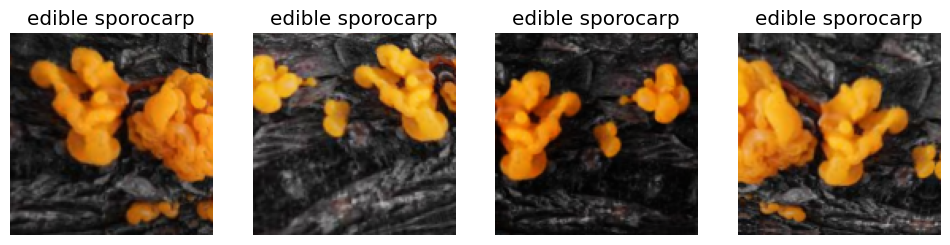

In [19]:
#augment some images, display a few for fun
mushrooms = mushrooms.new(
  item_tfms=Resize(128),
  batch_tfms=aug_transforms()
)
dls = mushrooms.dataloaders(dataset_path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [20]:
#train the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.708024,1.096892,0.376471,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.164634,0.861926,0.302941,00:14
1,0.940257,0.764054,0.272059,00:13
2,0.716830,0.721404,0.258824,00:14
3,0.585165,0.712951,0.258824,00:13


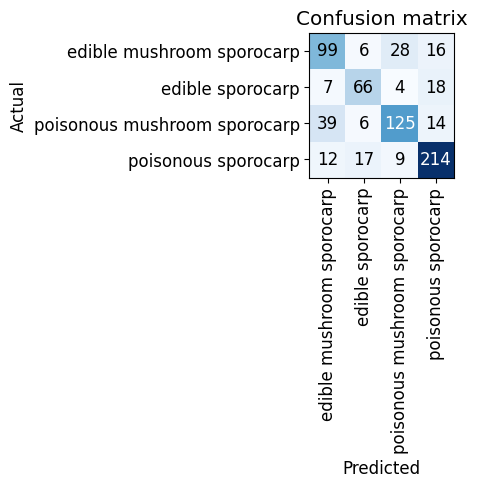

In [21]:
#display the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#unlink any bad data we found
for i in cleaner.delete(): cleaner.fns[i].unlink()

In [ ]:
#move any mis-categorizations
for i,cat in cleaner.change(): shutil.move(str(cleaner.fns[i]), path/cat)

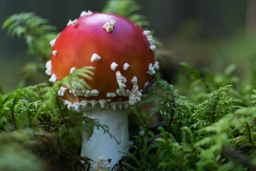

In [40]:
#fetch some new test data to maunally verify against the model
test_urls = search_images('morell mushroom', max_images=1)
morell_dest = 'morell-example.jpg'
download_url(test_urls[0], morell_dest, show_progress=False)

test_im = Image.open(morell_dest)
test_im.to_thumb(256,256)

test_urls2 = search_images('deathcap mushroom', max_images=1)
deathcap_dest = 'deathcap-example.jpg'
download_url(test_urls2[0], deathcap_dest, show_progress=False)

test_im2 = Image.open(deathcap_dest)
test_im2.to_thumb(256,256)

In [41]:
def print_prediction(img):
  pred,_,probs = learn.predict(img)
  print(f"This is a {pred}, probability: {probs[0]:.4f}")

print_prediction(test_im)
print_prediction(test_im2)

This is a edible sporocarp, probability: 0.0000


This is a poisonous mushroom sporocarp, probability: 0.0004


In [43]:
learn.export()